In [54]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.constants import hbar
import matplotlib.pyplot as plt
from scipy.misc import derivative

In [19]:
mp_key = "0TSH4JPmYApoWkybWbmreInYgdHzp5GT"
mp_id = "mp-29678"

In [20]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Densité électronique et bandes d'énergie

In [22]:
print("Bandes d'énergies: ")
fig_el_bs = get_plot_bs(el_bs, plot_range=[-4,7])
fig_el_bs.show()

Bandes d'énergies: 


On peut observer en abcisse du graphe les différentes direction dans lesquelles on a tracé la variation de l'énergie E-$E_F$ en fonction du vecteur d'onde k. Il s'agit des différentes directions dans la première zone de Brillouin que l'on peut observer ci-dessous.

In [24]:
plot_brillouin_zone(el_bs.structure)

In [11]:
print("Densité d'électrons: ")
fig_el_dos = get_plot_dos(el_dos, plot_range=[-4,7])
fig_el_dos.show()

Densité d'électrons: 


In [9]:
print("Bandes d'énergies avec la densité d'électrons: ")
fig_el_bs_and_dos = get_plot_bs_and_dos(el_bs, el_dos, plot_range=[-4,7])
fig_el_bs_and_dos.show()

Bandes d'énergies avec la densité d'électrons: 


In [50]:
infos_gap = el_bs.get_band_gap()
if (infos_gap.get('direct')): 
    print("Type de la bande interdite : directe")
else:
    print("Type de la bande interdite : indirecte")
print("Energie de la bande interdite (eV): ", infos_gap.get('energy'))
print("Vecteur d'onde de transition : ", infos_gap.get('transition'))
cbm = el_bs.get_cbm()
print("Numéro de la première bande de conduction: ", cbm['band_index'])
vbm = el_bs.get_vbm()
print("Numéro de la dernière bande de conduction: ",vbm['band_index'])
print("Il faut ajouter 1 pour obtenir le même numéro de bande que sur le graphe. ")

Type de la bande interdite : indirecte
Energie de la bande interdite (eV):  0.9135999999999997
Vecteur d'onde de transition :  (0.188,-0.000,-0.188)-\Gamma
Numéro de la première bande de conduction:  defaultdict(<class 'list'>, {<Spin.up: 1>: [14]})
Numéro de la dernière bande de conduction:  defaultdict(<class 'list'>, {<Spin.up: 1>: [13]})
Il faut ajouter 1 pour obtenir le même numéro de bande que sur le graphe 


La bande interdite se situe au niveau du gap d'énergie où la densité électronique est nulle. Dans le AgBiS2, on peut voir la présence de 2 bandes interdites on ne va étudier que celle à proximité du niveau de Fermi.

On peut aussi observer que la bande interdite est indirecte car le minimum de la bande de conduction ne correspond pas au même vecteur d'onde que le maximum de la bande de valence. Ainsi, lorsque qu'un électron passe de la bande de valence à la bande de conduction, il doit obtenir une énergie de 0.9136eV et doit subir un changement de vecteur d'onde donné par le vecteur (0.188,-0.000,-0.188) où chaque composante est selon les vecteurs du réseau récipoque (a*, b*, c*), ce qui correspond sur les abcisses à la direction $\Gamma$-X|Q.

# Relation de dispersion

La relation de dispersion relie l'énerie des électrons et leur vecteur d'onde. Dans une direction de la première zone de Brillouin, plus la pente de la droite reliant les 2 extrémités de l'intervalle correspondant à cette direction dans le graphe des bandes d'énergie est élevée en valeur absolue, plus la direction présente de dispersion.

In [52]:
bsp = BSPlotter(el_bs)
data = bsp.bs_plot_data()
energy = data['energy']
distances = data['distances']
valence = []
conduction = []

#On met les différentes pentes dans les listes
for i in range(len(distances)) : 
    dx = distances[i][0] - distances[i][-1]
    
    dE_Valence = energy.get('1')[i][14][0] - energy.get('1')[i][14][-1]
    dE_Conduction = energy.get('1')[i][15][0] - energy.get('1')[i][15][-1]
    
    valence.append(abs(dE_Valence/dx))
    conduction.append(abs(dE_Conduction/dx))

#On trouve les valeurs des max et min de chaque bande
MAX_valence = max(valence)
MIN_valence = min(valence)
MAX_conduction = max(conduction)
MIN_conduction = min(conduction)
#On trouve les indices des max et min de chaque bande
val_max = valence.index(MAX_valence)
val_min = valence.index(MIN_valence)
cond_max = conduction.index(MAX_conduction)
cond_min = conduction.index(MIN_conduction)


print("Valeur de la dispersion maximale sur la dernière bande de valence :", MAX_valence, "[eV]")
print("Valeur de la dispersion minimale sur la dernière bande de valence :", MIN_valence, "[eV]")
print("Valeur de la dispersion maximale sur la première bande de conduction :", MAX_conduction, "[eV]")
print("Valeur de la dispersion minimale sur la première bande de conduction :", MIN_conduction, "[eV]")

Valeur de la dispersion maximale sur la dernière bande de valence : 1.5342256837635648 [eV]
Valeur de la dispersion minimale sur la dernière bande de valence : 0.1977447323443149 [eV]
Valeur de la dispersion maximale sur la première bande de conduction : 1.8171862817832967 [eV]
Valeur de la dispersion minimale sur la première bande de conduction : 0.3139321253067971 [eV]


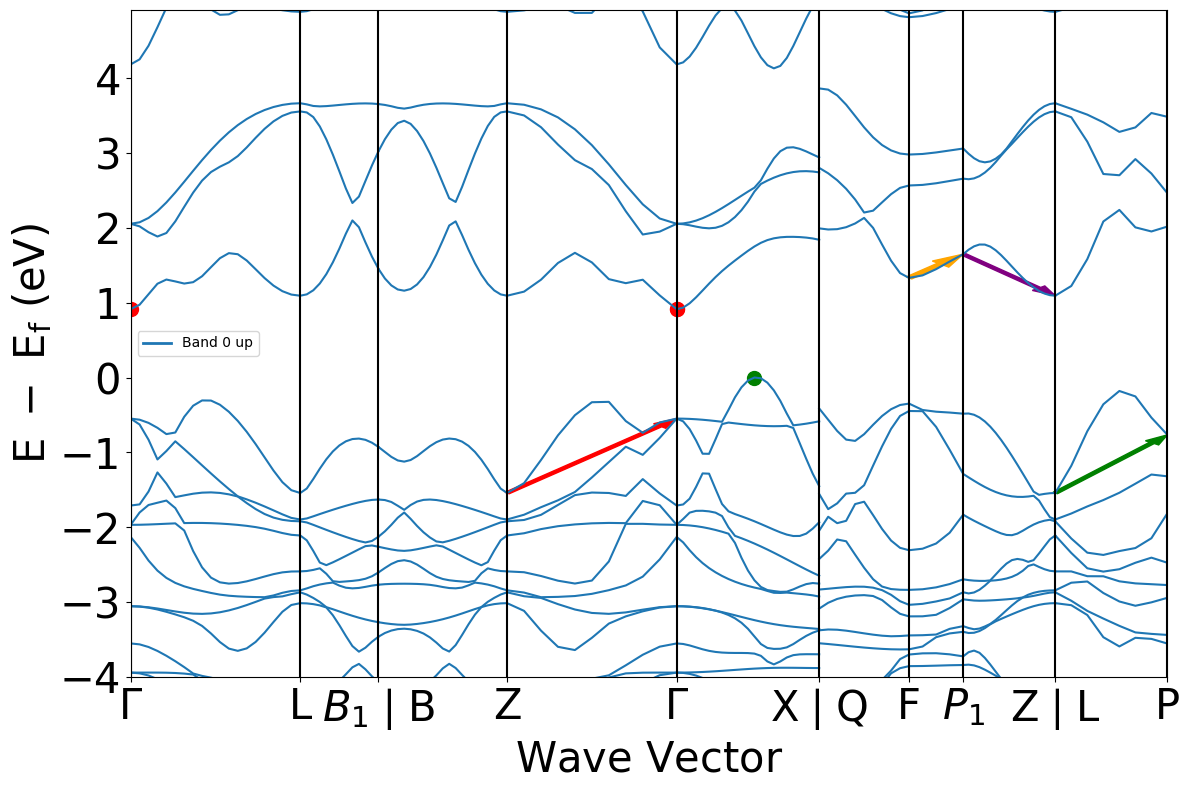

In [49]:
bsp.get_plot(vbm_cbm_marker = True)

#Dispersion min de la bande de valence 
plt.arrow(distances[val_min][0], energy['1'][val_min][13][0], 
          distances[val_min][-1]-distances[val_min][0], energy['1'][val_min][13][-1]-energy['1'][val_min][13][0],
          width = 0.03,length_includes_head=True,color='red') 

#Dispersion max de la bande de valence
plt.arrow(distances[val_max][0], energy['1'][val_max][13][0], 
          distances[val_max][-1]-distances[val_max][0], energy['1'][val_max][13][-1]-energy['1'][val_max][13][0],
          width = 0.03,length_includes_head=True,color='green') 

#Dispersion min de la bande de conduction
plt.arrow(distances[cond_min][0],energy['1'][cond_min][14][0], 
          distances[cond_min][-1]-distances[cond_min][0], energy['1'][cond_min][14][-1]-energy['1'][cond_min][14][0],
          width = 0.04,length_includes_head=True,color='orange')

#Dispersion max de la bande de conduction
plt.arrow(distances[cond_max][0], energy['1'][cond_max][14][0], 
          distances[cond_max][-1]-distances[cond_max][0], energy['1'][cond_max][14][-1]-energy['1'][cond_max][14][0],
          width = 0.03,length_includes_head=True,color='purple')

Chemin de dispersion maximale pour la bande de valence : $Z|L-P$

Chemin de dispersion minimale pour la bande de valence : $Z-\Gamma$

Chemin de dispersion maximale pour la bande de conduction : $P_1-Z|L$

Chemin de dispersion minimale pour la bande de conduction : $F-P_1$

# Masse effective

La masse effective est définie avec le tenseur d'ordre 2 des dérivées de l'énergie en fonction du vecteur d'onde, c'est à dire de la matrice Hessienne. Il est tout à fait possible d'avoir une masse effective nulle ou négative.

\begin{equation}
    m^*_{ij} = (\frac{\partial^2E}{\partial k_i \partial k_j})^{-1}
\end{equation}

On va supposer que l'on a une dispersion parabolique. On a donc 

\begin{equation}
    m^* = \frac{k^2\hbar^2}{2E}
\end{equation}

In [ ]:
#Constantes 
eV = 1.602e-19
A = 1e-10

#Valeurs k et énergie
valence_k = vbm['kpoint'].frac_coords
conduction_k = cbm['kpoint'].frac_coords

val_energy = vbm['energy']
cond_energy = cbm['energy']

val_masse = (hbar**2*(valence_k[0]**2+valence_k[1]**2+valence_k[2]**2))/(2*abs(val_energy)*eV*A)
cond_masse = (hbar**2*(conduction_k[0]**2+conduction_k[1]**2+conduction_k[2]**2))/(2*abs(cond_energy)*eV*A)

print("La masse effective au sommet de la bande de valence est de", val_masse, "kg")
print("La masse effective à la base de la bande de conduction est de", cond_masse, "kg")

La masse effective au sommet de la bande de valence est de 5.320554638904789e-42 kg
La masse effective à la base de la bande de conduction est de 0.0 kg
